Interesting LDA article: https://medium.com/data-science/practical-guide-to-topic-modeling-with-lda-05cd6b027bdf

Step-by-step: https://www.google.com/url?q=https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/&sa=D&source=docs&ust=1755572810705545&usg=AOvVaw3qRIvRnelPAxkHEFeDfU7F


In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning)

In [2]:
!pip install gensim
!pip install pyLDAvis

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 29 13:54:48 2025

@author: dnd2129
NLP processes
"""

import pandas as pd

import numpy as np

from google.colab import drive

import re

import spacy

from scipy.stats import uniform

from pprint import pprint

import gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans




#nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("omw-1.4")
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer


#Plots
#import pyLDAvis
#import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


now, combine all courses for each student into one row so we have one row per studnt. Then,tokenize it like I did above (choose uni/bi/trigrams or yaked keywords depending of which worked best).
THEN: only retain the tokens that I manually chose to use from the manual mapping.

# Grouping by student
One row per student-- adding a course_list column which contains all courses they have taken.

## Main DF

In [4]:
# mount gdrive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_excel("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/raw data/Project - Student Course Clustering/Student Course Elective Enrollments Graduates 2016-2025.xlsx")
df.head()

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,Combined Native Flag,Combined NHOPI Flag,Combined White Flag,Combined Federal Race,Slate Citizenship 2,Slate Citizenship 2.1,SIS Citizenship,Future Job Function,Future Job Industry,combined_name
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,Not American Indian or Alaska Native,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Transforming the Delivery of Healthcare Services
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,Not American Indian or Alaska Native,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Top Management Process
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,Not American Indian or Alaska Native,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,The Leader's Voice: Communication Skills for L...
3,19900,C002941648,aa2301,2016,20151MGMTB8536001,Elective,MGMTB8536,MANAGEMENT,1.5,HP,...,Not American Indian or Alaska Native,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Strategy and Competition in Pharmaceuticals an...
4,41190,C002941648,aa2301,2016,20153MGMTB8507002,Elective,MGMTB8507,MANAGEMENT,1.5,H-,...,Not American Indian or Alaska Native,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Organizational Change


### Cleaning Text
Cleaning combined name same way I did to obtain the yake keywords (in order to map exactly)

In [6]:

#cleaning texts
df['clean_name'] = df['combined_name'].fillna('') #changing nan to blank
df['clean_name'] = df['clean_name'].str.replace(r'\s+', ' ', regex=True)#cleaning new line chars
df['clean_name'] = df['clean_name'].str.replace("'", '', regex=False)#removing single quotes

df.head()


,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,Combined NHOPI Flag,Combined White Flag,Combined Federal Race,Slate Citizenship 2,Slate Citizenship 2.1,SIS Citizenship,Future Job Function,Future Job Industry,combined_name,clean_name
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Transforming the Delivery of Healthcare Services,Transforming the Delivery of Healthcare Services
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Top Management Process,Top Management Process
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,The Leader's Voice: Communication Skills for L...,The Leaders Voice: Communication Skills for Le...
3,19900,C002941648,aa2301,2016,20151MGMTB8536001,Elective,MGMTB8536,MANAGEMENT,1.5,HP,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Strategy and Competition in Pharmaceuticals an...,Strategy and Competition in Pharmaceuticals an...
4,41190,C002941648,aa2301,2016,20153MGMTB8507002,Elective,MGMTB8507,MANAGEMENT,1.5,H-,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Organizational Change,Organizational Change


#### Remove stopwords

In [7]:
def rem_sw(var_in):
    sw = list(set(stopwords.words('english')))
    tmp = [word for word in var_in.split() if word not in sw]
    return ' '.join(tmp)

In [8]:
df['clean_name'] = df['clean_name'].apply(rem_sw)
df.head()

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,Combined NHOPI Flag,Combined White Flag,Combined Federal Race,Slate Citizenship 2,Slate Citizenship 2.1,SIS Citizenship,Future Job Function,Future Job Industry,combined_name,clean_name
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Transforming the Delivery of Healthcare Services,Transforming Delivery Healthcare Services
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Top Management Process,Top Management Process
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,The Leader's Voice: Communication Skills for L...,The Leaders Voice: Communication Skills Leadin...
3,19900,C002941648,aa2301,2016,20151MGMTB8536001,Elective,MGMTB8536,MANAGEMENT,1.5,HP,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Strategy and Competition in Pharmaceuticals an...,Strategy Competition Pharmaceuticals Biotechno...
4,41190,C002941648,aa2301,2016,20153MGMTB8507002,Elective,MGMTB8507,MANAGEMENT,1.5,H-,...,Not Native Hawaiian or Other Pacific Islander,White,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Organizational Change,Organizational Change


# Title LDA

### Checking if any student doesnt have a course

In [9]:
no_course_mask = df["clean_name"].apply(lambda ks: len(ks) == 0)
n_no_crs = no_course_mask.sum()
n_total = len(df)

print(f"{n_no_crs} out of {n_total} students have no course_name.")


7701 out of 147048 students have no course_name.


## Importing the combined name and yake map

In [10]:
keyword_yake5_map = pd.read_csv("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/Student Cluster Analysis GDrive/keyword-yake5-map.csv")
keyword_yake5_map.head()

,combined_name,yake_top5_keywords
0,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa..."
1,Web App Programming in Python,"App Programming Python, Web App Programming, P..."
2,Virtual Reality & The Future of Storytelling: ...,"Technologies Transform Media, Disruptive Techn..."
3,Virtual Reality & Artificial Intelligence: How...,"Technologies Transform Media, Disruptive Techn..."
4,Virtual Reality & Artificial Intelligence,"Artificial Intelligence, Virtual Reality, Real..."


In [11]:
#Split the string into a list of keywords
keyword_yake5_map["keyword_list"] = keyword_yake5_map["yake_top5_keywords"].apply(
    lambda x: [kw.strip() for kw in re.split(r"[;,]", str(x)) if kw.strip()]
)

#Explode so each keyword gets its own row
keyword_long = keyword_yake5_map.explode("keyword_list", ignore_index=True)

#Renaming col
keyword_long = keyword_long.rename(columns={"keyword_list": "keyword"})

keyword_long.head(10)

,combined_name,yake_top5_keywords,keyword
0,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic Capabilities
1,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic Capabilities
2,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic
3,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Capabilities
4,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic
5,Web App Programming in Python,"App Programming Python, Web App Programming, P...",App Programming Python
6,Web App Programming in Python,"App Programming Python, Web App Programming, P...",Web App Programming
7,Web App Programming in Python,"App Programming Python, Web App Programming, P...",Programming Python
8,Web App Programming in Python,"App Programming Python, Web App Programming, P...",App Programming
9,Web App Programming in Python,"App Programming Python, Web App Programming, P...",Web App


### Keep MAP

Importing the manually coded csv which has that keywords to keep (keep map)

In [12]:
keep_map = pd.read_csv("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/Student Cluster Analysis GDrive/keywords_keep_map.csv")
keep_map.head()

,unique yake_top5_keywords,keep tag
0,Global,0
1,Business,1
2,Immersion,0
3,Management,1
4,Global Immersion,1


#### keep tagged keywords and drop the rest

merging with full keyword list with keep map to mark which to keep, along with lsit of keywords

In [13]:
tagged_keywords = keyword_long.merge(keep_map, left_on='keyword', right_on = "unique yake_top5_keywords", how='left')
tagged_keywords.head()


,combined_name,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag
0,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic Capabilities,Winning Strategic Capabilities,0.0
1,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic Capabilities,Strategic Capabilities,0.0
2,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic,Winning Strategic,0.0
3,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Capabilities,Capabilities,0.0
4,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic,Strategic,1.0


NOT filtering for kept keywords only yet as I want a fallback for coursenames which might not have any keywords after filtering out 0s in the keep tag. So, I want to lemmatize all keywords and retain it until the end just in case I can uses keep tag 0s as fallback for courses with no tags.

### Stemming and Lemmetize the keywords (Checking)

Adding them to the same dataframe as separate cols to test which might work best. I think lemmas should work best as it makes sure the tokens are actual words, unlike stemming.

In [14]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

tagged_keywords["stem"] = tagged_keywords["keyword"].apply(
    lambda x: stemmer.stem(x))

In [15]:
nlp = spacy.load("en_core_web_sm")
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

tagged_keywords['lemma'] = tagged_keywords['keyword'].apply(lambda x: lemmatize_text(x))
tagged_keywords.head()


,combined_name,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma
0,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic Capabilities,Winning Strategic Capabilities,0.0,winning strategic cap,win Strategic Capabilities
1,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic Capabilities,Strategic Capabilities,0.0,strategic cap,Strategic Capabilities
2,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic,Winning Strategic,0.0,winning strateg,win strategic
3,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Capabilities,Capabilities,0.0,capabl,capability
4,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic,Strategic,1.0,strateg,strategic


After running with normal lemmatizer, I noticed some discrapencies which I will manually override (below) to make sure certain tokens converge

In [16]:
lemm = WordNetLemmatizer()

# Explicit fixes for tricky derivations
OVERRIDES = {
    "financial": "finance",
    "finance": "finance",
    "finances":"finance",
    "analytics": "analysis",
    "analysis": "analysis",
    "accounting": "accounting",
    "accounts":"accounting",
    "accounting":"accounting",
    "family" : "family",
    "art":"art",
    "arts":"art",
    "invest": "investing",
    "investing":"investing",
    "investment":"investing",
    "entrepreneurship": "entrepreneurship",
    "entrepreneurial": "entrepreneurship",
    "entrepreneur": "entrepreneurship",
    "tech":"technology",
    "technology": "technology",
    "technological":"technology",
    "technologies":"technology",
    "digital":"technology",
    "risk":"rise",
    "science":"science",
    "sciences":"science",
    "scientist":"science",
    "consulting":"consulting",
    "consultant":"consulting",
    "consult":"consulting",
    "consultancy": "consulting",
    "pharma":"pharmaceutical",
    "pharmaceutical":"pharmaceutical",
    "pharmaceuticals":"pharmaceutical",
    "health":"healthcare",
    "healthcare":"healthcare",
    "retailing":"retail",
    "retail":"retail",
    "leader":"leadership",
    "leadership":"leadership",
    "strategy":"strategy",
    "strategies":"strategy",
    "strategic":"strategy",
    "products":"product",
    "security":"securities",
    "securities":"securities",
    "macroeconomic":"macroeconomic",
    "macroeconomy":"macroeconomic",
    "start-up":"startup",
    "startup":"startup",
    "securities analysis":"security analysis",
    "economy":"economy",
    "economic":"economy",
    "economics":"economy",
    "activist":"activism",
    "activism":"activism",
    "sale":"sales",
    "sales":"sales",
    "big":"big data",
    "estate":"real estate",
    "real":"real estate",
    "sustainable":"sustainability",
    "medium":"",
    "program":"",
    "rise":"",
}

def get_root_one(word: str) -> str:
    if not isinstance(word, str) or not word.strip():
        return word
    w = word.strip().lower()
    if w in OVERRIDES:
        return OVERRIDES[w]

    candidates = []
    for ss in wn.synsets(w):
        for lem in ss.lemmas():
            for rel in lem.derivationally_related_forms():
                form = rel.name().lower().replace("_", " ")
                pos  = rel.synset().pos()   # 'n','v','a','r','s'
                freq = rel.count()          # WordNet frequency
                candidates.append((form, pos, freq))

    # add fallbacks (original + simple lemmas)
    candidates.append((w, 'x', 0))
    candidates.append((lemm.lemmatize(w, 'n'), 'n', 0))
    candidates.append((lemm.lemmatize(w, 'v'), 'v', 0))
    candidates.append((lemm.lemmatize(w, 'a'), 'a', 0))

    # pick best: prefer nouns, then higher frequency, then shorter string
    form = sorted(candidates, key=lambda t: (t[1] != 'n', -t[2], len(t[0]), t[0]))[0][0]
    return form

# Apply (returns a single token per keyword)
tagged_keywords["lemma_root"] = tagged_keywords["keyword"].apply(get_root_one)
tagged_keywords.head()


,combined_name,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma,lemma_root
0,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic Capabilities,Winning Strategic Capabilities,0.0,winning strategic cap,win Strategic Capabilities,winning strategic capabilities
1,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic Capabilities,Strategic Capabilities,0.0,strategic cap,Strategic Capabilities,strategic capabilities
2,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Winning Strategic,Winning Strategic,0.0,winning strateg,win strategic,winning strategic
3,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Capabilities,Capabilities,0.0,capabl,capability,capability
4,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic,Strategic,1.0,strateg,strategic,strategy


lemma_root has the keywords I want (lemma has some deviations and doesn't have the manual override).

### Fitlering only for keywords we want to keep (keep == 1)

In [17]:
kept_keywords = tagged_keywords[tagged_keywords["keep tag"] == 1]
kept_keywords.head()

,combined_name,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma,lemma_root
4,Winning Strategic Capabilities,"Winning Strategic Capabilities, Strategic Capa...",Strategic,Strategic,1.0,strateg,strategic,strategy
14,Virtual Reality & The Future of Storytelling: ...,"Technologies Transform Media, Disruptive Techn...",Virtual Reality,Virtual Reality,1.0,virtual r,virtual reality,virtual reality
17,Virtual Reality & Artificial Intelligence: How...,"Technologies Transform Media, Disruptive Techn...",Artificial Intelligence,Artificial Intelligence,1.0,artificial intellig,Artificial Intelligence,artificial intelligence
19,Virtual Reality & Artificial Intelligence: How...,"Technologies Transform Media, Disruptive Techn...",Virtual Reality,Virtual Reality,1.0,virtual r,virtual reality,virtual reality
20,Virtual Reality & Artificial Intelligence,"Artificial Intelligence, Virtual Reality, Real...",Artificial Intelligence,Artificial Intelligence,1.0,artificial intellig,Artificial Intelligence,artificial intelligence


In [18]:
kept_keywords['clean_name'] = kept_keywords['combined_name'].fillna('') #changing nan to blank
kept_keywords['clean_name'] = kept_keywords['clean_name'].str.replace(r'\s+', ' ', regex=True)#cleaning new line chars
kept_keywords['clean_name'] =kept_keywords['clean_name'].str.replace("'", '', regex=False)#removing single quotes
kept_keywords['clean_name'] = kept_keywords['clean_name'].apply(rem_sw)

/tmp/ipython-input-2897937140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_keywords['clean_name'] = kept_keywords['combined_name'].fillna('') #changing nan to blank
/tmp/ipython-input-2897937140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_keywords['clean_name'] = kept_keywords['clean_name'].str.replace(r'\s+', ' ', regex=True)#cleaning new line chars
/tmp/ipython-input-2897937140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [19]:
kept_keywords.tail()

,combined_name,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma,lemma_root,clean_name
2477,Accounting for Consultants,"Accounting Consultants, Consultants, Accounting",Accounting,Accounting,1.0,account,accounting,accounting,Accounting Consultants
2479,A Strategic Marketing Approach To Private Equi...,"Strategic Marketing Approach, Emerging Markets...",Emerging Markets,Emerging Markets,1.0,emerging market,emerge market,emerging markets,A Strategic Marketing Approach To Private Equi...
2487,A Closer Look at the Start-Up Nation,"Start-Up Nation, Closer Look Start-Up, Nation,...",Start-Up,Start-Up,1.0,start-up,start - up,startup,A Closer Look Start-Up Nation
2489,PhD Valuation and Financial Statement Analysis,"Valuation Financial Statement, Financial State...",Financial Statement Analysis,Financial Statement Analysis,1.0,financial statement analysi,Financial Statement Analysis,financial statement analysis,PhD Valuation Financial Statement Analysis
2506,PhD Behavioral Finance,"Behavioral Finance, PhD, Behavioral, Finance",Finance,Finance,1.0,financ,finance,finance,PhD Behavioral Finance


In [20]:
kept_keywords.to_csv("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/Student Cluster Analysis GDrive/stem_lemmatized_kept_keywords.csv")

#### Looks like lemma_root might be best to use for LDA model training!!! :) buuuut-- need to merge with df on clean_name first.

## Some courses don't have keywords--- this is a problem as we will miss those courses in our LDA. For courses without a keyword, I will use keywords from the course descriptions!

### Merging df with course Descriptions
need to add year-term in the format 20193 to df as ill need to merge on term AND clean_name because descriptions are different across years

In [21]:
#get first 5 chars of Unique_Course_ID
df['yearTerm'] = df['Unique_Course_ID'].str[:5]
df["course_number"] = df['Course_Identifier'].str[4:]
df.head(2)

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,Combined Federal Race,Slate Citizenship 2,Slate Citizenship 2.1,SIS Citizenship,Future Job Function,Future Job Industry,combined_name,clean_name,yearTerm,course_number
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Transforming the Delivery of Healthcare Services,Transforming Delivery Healthcare Services,20153,B8118
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,Two or More,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Top Management Process,Top Management Process,20153,B8515


In [22]:
desc = pd.read_csv("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/raw data/Project - Student Course Clustering/Up to 20213 Course Descriptions.csv")
desc["yearTerm"] = desc["yearTerm"].astype(str).str[:5]
desc.head()

,yearTerm,course_number,section,course_title,course_description
0,20213,B8444,1,Modern Value,"You might have heard that value, quant value t..."
1,20203,B8467,1,The Economics and Politics of Digital Disruption,You canâ€™t disrupt any industry without dislo...
2,20213,B8467,1,The Economics and Politics of Digital Disruption,You can&rsquo;t disrupt any industry without d...
3,20181,B9651,1,MS Marketing Analytics,You are a manager in a large corporation taske...
4,20163,B8617,1,Marketing Research and Analytics,You are a manager in a large corporation taske...


In [23]:
desc["clean_name"] = desc["course_title"].fillna('') #changing nan to blank
desc['clean_name'] = desc['clean_name'].str.replace(r'\s+', ' ', regex=True)#cleaning new line chars
desc['clean_name'] = desc['clean_name'].str.replace("'", '', regex=False)#removing single quotes

desc["course_description"] = desc["course_description"].fillna('') #changing nan to blank
desc['course_description'] = desc['course_description'].str.replace(r'\s+', ' ', regex=True)#cleaning new line chars
desc['course_description'] = desc['course_description'].str.replace("'", '', regex=False)#removing single quotes
desc.head()

,yearTerm,course_number,section,course_title,course_description,clean_name
0,20213,B8444,1,Modern Value,"You might have heard that value, quant value t...",Modern Value
1,20203,B8467,1,The Economics and Politics of Digital Disruption,You canâ€™t disrupt any industry without dislo...,The Economics and Politics of Digital Disruption
2,20213,B8467,1,The Economics and Politics of Digital Disruption,You can&rsquo;t disrupt any industry without d...,The Economics and Politics of Digital Disruption
3,20181,B9651,1,MS Marketing Analytics,You are a manager in a large corporation taske...,MS Marketing Analytics
4,20163,B8617,1,Marketing Research and Analytics,You are a manager in a large corporation taske...,Marketing Research and Analytics


In [24]:
desc['clean_name'] = desc['clean_name'].apply(rem_sw)
desc["course_description"] = desc["course_description"].apply(rem_sw)
desc.head()

,yearTerm,course_number,section,course_title,course_description,clean_name
0,20213,B8444,1,Modern Value,"You might heard value, quant value specific, p...",Modern Value
1,20203,B8467,1,The Economics and Politics of Digital Disruption,You canâ€™t disrupt industry without dislodgin...,The Economics Politics Digital Disruption
2,20213,B8467,1,The Economics and Politics of Digital Disruption,You can&rsquo;t disrupt industry without dislo...,The Economics Politics Digital Disruption
3,20181,B9651,1,MS Marketing Analytics,You manager large corporation tasked making ma...,MS Marketing Analytics
4,20163,B8617,1,Marketing Research and Analytics,You manager large corporation tasked making ma...,Marketing Research Analytics


In [25]:
print("df count:", df['clean_name'].count())
print("desc count:",desc['clean_name'].count())

df count: 147048
desc count: 14613


In [26]:
desc_only = desc[["yearTerm","course_number", "clean_name", 'course_description']]
desc_only.head()

,yearTerm,course_number,clean_name,course_description
0,20213,B8444,Modern Value,"You might heard value, quant value specific, p..."
1,20203,B8467,The Economics Politics Digital Disruption,You canâ€™t disrupt industry without dislodgin...
2,20213,B8467,The Economics Politics Digital Disruption,You can&rsquo;t disrupt industry without dislo...
3,20181,B9651,MS Marketing Analytics,You manager large corporation tasked making ma...
4,20163,B8617,Marketing Research Analytics,You manager large corporation tasked making ma...


In [27]:
df_desc = df.merge(desc_only,
                       on=["clean_name", "yearTerm", "course_number"],
                       how="left")
df_desc.head()

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,Slate Citizenship 2,Slate Citizenship 2.1,SIS Citizenship,Future Job Function,Future Job Industry,combined_name,clean_name,yearTerm,course_number,course_description
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Transforming the Delivery of Healthcare Services,Transforming Delivery Healthcare Services,20153,B8118,"This course provides advanced, critical analys..."
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Top Management Process,Top Management Process,20153,B8515,&amp;amp;lt;span itemprop=&amp;amp;quot;name&a...
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,The Leader's Voice: Communication Skills for L...,The Leaders Voice: Communication Skills Leadin...,20151,B8538,The Leaders Voice: Communication Skills Leadin...
3,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,The Leader's Voice: Communication Skills for L...,The Leaders Voice: Communication Skills Leadin...,20151,B8538,Prerequisite: Students must completed course B...
4,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,The Leader's Voice: Communication Skills for L...,The Leaders Voice: Communication Skills Leadin...,20151,B8538,Prerequisite: Students must completed course B...


In [28]:
print("df_desc count:", df_desc['clean_name'].count())

df_desc count: 234130


In [29]:
#drop duplicates from df_desc wth same clean_name, yearTerm and uni
df_desc_clean = df_desc.drop_duplicates(subset=['clean_name', 'yearTerm', 'uni', "course_number"])
print("df_desc_clean count:", df_desc_clean['clean_name'].count())
df_desc_clean.head() #147048-- same number as original df!!

df_desc_clean count: 147048


,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,Slate Citizenship 2,Slate Citizenship 2.1,SIS Citizenship,Future Job Function,Future Job Industry,combined_name,clean_name,yearTerm,course_number,course_description
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Transforming the Delivery of Healthcare Services,Transforming Delivery Healthcare Services,20153,B8118,"This course provides advanced, critical analys..."
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Top Management Process,Top Management Process,20153,B8515,&amp;amp;lt;span itemprop=&amp;amp;quot;name&a...
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,The Leader's Voice: Communication Skills for L...,The Leaders Voice: Communication Skills Leadin...,20151,B8538,The Leaders Voice: Communication Skills Leadin...
9,19900,C002941648,aa2301,2016,20151MGMTB8536001,Elective,MGMTB8536,MANAGEMENT,1.5,HP,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Strategy and Competition in Pharmaceuticals an...,Strategy Competition Pharmaceuticals Biotechno...,20151,B8536,"This course examines strategic, technological,..."
10,41190,C002941648,aa2301,2016,20153MGMTB8507002,Elective,MGMTB8507,MANAGEMENT,1.5,H-,...,United States,NaN,United States,Fin. - Management,Healthcare / Biotechnology / Pharmaceuticals,Organizational Change,Organizational Change,20153,B8507,"This course focused organizations change, chan..."


for courses with no keywords, I'm going to get their Top 1 keyword using YAKE on course_description (from desc df) , then get lemma_root their yaked_top_1 again as these courses don't seem to be picked up in the keyword_long df itself. Courses with nas with missing in the df_keywords were merged out because they don't exist in "kept_keywords" df, which means they don't exist in the "keywords_long" df.


## Merging df_desc with keywords

In [60]:
df_keywords = df_desc_clean.merge(
    kept_keywords,
    on='clean_name',
    how='left'   # <-- keep ALL courses
)

df_keywords.head()

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,course_number,course_description,combined_name_y,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma,lemma_root
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,B8118,"This course provides advanced, critical analys...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,B8515,&amp;amp;lt;span itemprop=&amp;amp;quot;name&a...,Top Management Process,"Top Management Process, Management Process, To...",Management,Management,1.0,manag,management,management
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,B8538,The Leaders Voice: Communication Skills Leadin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19900,C002941648,aa2301,2016,20151MGMTB8536001,Elective,MGMTB8536,MANAGEMENT,1.5,HP,...,B8536,"This course examines strategic, technological,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41190,C002941648,aa2301,2016,20153MGMTB8507002,Elective,MGMTB8507,MANAGEMENT,1.5,H-,...,B8507,"This course focused organizations change, chan...",Organizational Change,"Organizational Change, Change, Organizational",Organizational Change,Organizational Change,1.0,organizational chang,Organizational change,organizational change


In [61]:
df_keywords.tail()

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,course_number,course_description,combined_name_y,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma,lemma_root
228778,121733,C004680521,zz3072,2025,20241FINCB8306001,Elective,FINCB8306,FINANCE,3.0,H,...,B8306,NaN,Capital Markets & Investments,"Capital Markets, Investments, Markets, Capital",Investments,Investments,1.0,invest,investment,investment
228779,121733,C004680521,zz3072,2025,20241FINCB8306001,Elective,FINCB8306,FINANCE,3.0,H,...,B8306,NaN,Capital Markets & Investments,"Capital Markets, Investments, Markets, Capital",Markets,Markets,1.0,market,market,marketing
228780,137814,C004680521,zz3072,2025,20241FINCB8307001,Elective,FINCB8307,FINANCE,3.0,H,...,B8307,NaN,Advanced Corporate Finance,"Advanced Corporate Finance, Corporate Finance,...",Corporate Finance,Corporate Finance,1.0,corporate fin,Corporate Finance,corporate finance
228781,137814,C004680521,zz3072,2025,20241FINCB8307001,Elective,FINCB8307,FINANCE,3.0,H,...,B8307,NaN,Advanced Corporate Finance,"Advanced Corporate Finance, Corporate Finance,...",Finance,Finance,1.0,financ,finance,finance
228782,137814,C004680521,zz3072,2025,20241FINCB8307001,Elective,FINCB8307,FINANCE,3.0,H,...,B8307,NaN,Advanced Corporate Finance,"Advanced Corporate Finance, Corporate Finance,...",Corporate,Corporate,1.0,corpor,corporate,corporate


In [92]:
print("df_keywords count:", df_keywords['clean_name'].count()) #228783

df_keywords count: 228783


In [93]:
#count NAs
df_keywords["lemma_root"].isna().sum() #37505

37505

In [94]:
df_keywords['keyword'].isna().sum()  #37505

37505

In [95]:
df_keywords['combined_name_x'].isna().sum() #7701

7701

In [96]:
df_keywords['combined_name_y'].isna().sum() #37505

37505

In [97]:
 rows_with_na = df_keywords[df_keywords['lemma_root'].isnull()]
 rows_with_na.head()

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,course_number,course_description,combined_name_y,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma,lemma_root
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,B8118,"This course provides advanced, critical analys...",NaN,"[healthcare, care, health, Act, providers]",NaN,NaN,NaN,NaN,NaN,NaN
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,B8538,The Leaders Voice: Communication Skills Leadin...,NaN,"[Students, Voice, Prerequisite, officer, Devel...",NaN,NaN,NaN,NaN,NaN,NaN
3,19900,C002941648,aa2301,2016,20151MGMTB8536001,Elective,MGMTB8536,MANAGEMENT,1.5,HP,...,B8536,"This course examines strategic, technological,...",NaN,"[Strategies, sector, development, regulatory, ...",NaN,NaN,NaN,NaN,NaN,NaN
7,48774,C002941648,aa2301,2016,20151MRKTB8608001,Elective,MRKTB8608,MARKETING,1.5,H-,...,B8608,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
10,75737,C002941648,aa2301,2016,20151MRKTB8568001,Elective,MRKTB8568,MARKETING,1.5,H,...,B8568,The Managing Customer Experiences seminar give...,NaN,"[Experiences, customers, companies, Managing, ...",NaN,NaN,NaN,NaN,NaN,NaN


## Yaking courses without keywords from coursetitle

In [39]:
!pip install yake

Now, I will use a function that goes through all the top 5 yaked keywords for these courses with Na in "keyword" column-- I will be using YAKED DESCRIPTION keywords. For each row,  I will look inside the "yake_top5_keywords" for keywords which have 1 in the keep map. where it does, that will be the "keyword". if there isn't one, they I will just pick the first keyword in "yake_top5_keyword". Then, I will apply the get_root_one function for these keywords only. the lemma root col will then be populated for those which had NA.

In [98]:
'''
# --- YAKE setup (unigrams) --- Taking so long to run. -- so wirting output to csv-- can just read that
from yake import KeywordExtractor
import re
import numpy as np

# Use a slightly deeper top-k so we have more chances to overlap with keep_set
kw_extractor_5  = KeywordExtractor(lan="en", n=1, top=5)
kw_extractor_20 = KeywordExtractor(lan="en", n=1, top=20)

def yake_top_keywords(text, extractor):
    """Return a ranked list of YAKE keyword strings or None."""
    if pd.isna(text):
        return None
    s = str(text).strip()
    if not s:
        return None
    try:
        return [kw for kw, score in extractor.extract_keywords(s)]
    except Exception:
        return None

def simple_token_fallback(text):
    """Very light fallback: first alphabetic token 3+ chars from text, or None."""
    if pd.isna(text):
        return None
    for tok in re.findall(r"[A-Za-z][A-Za-z\-]{2,}", str(text)):
        return tok.lower()
    return None

# Work on a fresh copy
df_keywords_final = df_keywords.copy(deep=True)

# Always a LIST (or None) for description-based candidates
df_keywords_final["desc_yake_top5"]  = df_keywords_final["course_description"].apply(lambda t: yake_top_keywords(t, kw_extractor_5))
df_keywords_final["desc_yake_top20"] = df_keywords_final["course_description"].apply(lambda t: yake_top_keywords(t, kw_extractor_20))

# --- Approved vocabulary (lowercased) ---
keep_set = set(
    tagged_keywords.loc[tagged_keywords["keep tag"] == 1, "unique yake_top5_keywords"]
    .dropna().astype(str).str.strip().str.lower()
)

def choose_keyword(row):
    """
    Priority:
      1) If title-based 'keyword' exists -> keep it.
      2) Else, scan desc YAKE candidates IN ORDER (top-5). If any in keep_set, return first match.
      3) Else, if no overlap in top-5, scan the extended top-20 list for a keep_set match.
      4) Else, pick the top YAKE(desc) candidate (OOV fallback) so it's never NA.
      5) If YAKE returns nothing, use a simple token from description (very rare).
    """
    k = row.get("keyword")
    if pd.notna(k) and str(k).strip():
        return k

    cands5  = row.get("desc_yake_top5")  or []
    cands20 = row.get("desc_yake_top20") or []

    # Step 2: first overlap from top-5 (rank preserved)
    for cand in cands5:
        if str(cand).strip().lower() in keep_set:
            return cand

    # Step 3: widen search to top-20 for overlap
    for cand in cands20:
        if str(cand).strip().lower() in keep_set:
            return cand

    # Step 4: OOV fallback to top YAKE(desc) candidate
    if len(cands5) > 0:
        return cands5[0]
    if len(cands20) > 0:
        return cands20[0]

    # Step 5: extreme fallback from raw description
    fallback = simple_token_fallback(row.get("course_description"))
    return fallback  # may still be None in worst case

# Fill keywords using the new logic
df_keywords_final["keyword"] = df_keywords_final.apply(choose_keyword, axis=1)

# --- Lemmatization backfill ---
def safe_root(tok):
    """Use lemmatizer; if it returns None/empty, fall back to the token itself."""
    if tok is None or (isinstance(tok, float) and pd.isna(tok)):
        return None
    out = get_root_one(tok)
    if out is None or (isinstance(out, float) and pd.isna(out)) or str(out).strip() == "":
        return str(tok).strip().lower()
    return str(out).strip().lower()

# Only compute roots where lemma_root is NA and keyword now exists
needs_root = df_keywords_final["lemma_root"].isna() & df_keywords_final["keyword"].notna()
df_keywords_final.loc[needs_root, "lemma_root"] = df_keywords_final.loc[needs_root, "keyword"].apply(safe_root)

# Final guard: ensure EVERY course has a lemma_root if it has a keyword
df_keywords_final["lemma_root"] = df_keywords_final["lemma_root"].where(
    df_keywords_final["lemma_root"].notna(),
    df_keywords_final["keyword"].apply(lambda x: str(x).strip().lower() if pd.notna(x) else x)
)

# Normalize keyword casing at the end
df_keywords_final["keyword"] = df_keywords_final["keyword"].apply(
    lambda x: str(x).strip().lower() if pd.notna(x) else x
)
'''


In [115]:
# wrte to csv
#df_keywords_final.to_csv("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/Student Cluster Analysis GDrive/df_keywords_final.csv")

In [114]:
df_keywords_final = pd.read_csv("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/Student Cluster Analysis GDrive/def_keywords_final.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/Student Cluster Analysis GDrive/def_keywords_final.csv'

In [112]:
oov_mask = (
    df_keywords_final["keyword"].notna() &
    ~df_keywords_final["keyword"].str.lower().isin(keep_set)
)
df_keywords_final[oov_mask][["combined_name_x","combined_name_y","keyword","desc_yake_top5","lemma_root"]].head()

,combined_name_x,combined_name_y,keyword,desc_yake_top5,lemma_root
174,Power & Influence,NaN,power,"[Power, influence, organizations, leaders, kno...",power
218,Media Platforms and Content: A Foundations Course,NaN,mozallowfullscreen,"[mozallowfullscreen, src]",mozallowfullscreen
267,Alternative Assets in Institutional Portfolios,NaN,mozallowfullscreen,"[mozallowfullscreen, src]",mozallowfullscreen
284,Fundamentals of Governance,NaN,mozallowfullscreen,"[mozallowfullscreen, src]",mozallowfullscreen
868,Power & Influence,NaN,power,"[Power, influence, organizations, leaders, kno...",power


In [104]:
df_keywords_final.head()

,Unnamed: 0,Person_ID_Number,uni,Grad_Year,Unique_Course_ID,Core_Elective,Course_Identifier,Subject_Name,Credits_Awarded_Count,Final_Grade_Code,...,combined_name_y,yake_top5_keywords,keyword,unique yake_top5_keywords,keep tag,stem,lemma,lemma_root,desc_yake_top5,desc_yake_top20
0,5085,C002941648,aa2301,2016,20153DROMB8118001,Elective,DROMB8118,"DEC,RISK & OPERATIONS MGT",1.5,P1+,...,NaN,"[healthcare, care, health, Act, providers]",healthcare,NaN,NaN,NaN,NaN,healthcare,"[healthcare, care, health, Act, providers]","[healthcare, care, health, Act, providers, adv..."
1,5434,C002941648,aa2301,2016,20153MGMTB8515001,Elective,MGMTB8515,MANAGEMENT,3.0,HP,...,Top Management Process,Management,management,Management,1.0,manag,management,management,"[amp, quot, span, content, itemprop]","[amp, quot, span, content, itemprop, Top, Mana..."
2,9020,C002941648,aa2301,2016,20151MGMTB8538007,Elective,MGMTB8538,MANAGEMENT,1.5,H,...,NaN,"[Students, Voice, Prerequisite, officer, Devel...",leadership,NaN,NaN,NaN,NaN,leadership,"[Students, Voice, Prerequisite, officer, Devel...","[Students, Voice, Prerequisite, officer, Devel..."
3,19900,C002941648,aa2301,2016,20151MGMTB8536001,Elective,MGMTB8536,MANAGEMENT,1.5,HP,...,NaN,"[Strategies, sector, development, regulatory, ...",strategies,NaN,NaN,NaN,NaN,strategy,"[Strategies, sector, development, regulatory, ...","[Strategies, sector, development, regulatory, ..."
4,41190,C002941648,aa2301,2016,20153MGMTB8507002,Elective,MGMTB8507,MANAGEMENT,1.5,H-,...,Organizational Change,Organizational Change,organizational change,Organizational Change,1.0,organizational chang,Organizational change,organizational change,"[change, organizations, agents, focused, agent]","[change, organizations, agents, focused, agent..."


In [105]:
# How many lemma_root NAs before vs after?
before = df_keywords["lemma_root"].isna().sum()
after  = df_keywords_final["lemma_root"].isna().sum()
print({"lemma_root_na_before": before, "lemma_root_na_after": after})

# Spot-check rows that changed from NA -> filled
changed = df_keywords["lemma_root"].isna() & df_keywords_final["lemma_root"].notna()
df_keywords_final.loc[changed, ["combined_name_x","keyword","lemma_root","desc_yake_top5"]].head(10)


{'lemma_root_na_before': 37505, 'lemma_root_na_after': 22058}


,combined_name_x,keyword,lemma_root,desc_yake_top5
0,Transforming the Delivery of Healthcare Services,healthcare,healthcare,"[healthcare, care, health, Act, providers]"
2,The Leader's Voice: Communication Skills for L...,leadership,leadership,"[Students, Voice, Prerequisite, officer, Devel..."
3,Strategy and Competition in Pharmaceuticals an...,strategies,strategy,"[Strategies, sector, development, regulatory, ..."
10,Immersion Seminar: Experience Brand Cultures,managing,manager,"[Experiences, customers, companies, Managing, ..."
12,Forecasting for Drug Development Strategy,data,data,"[data, providers, œblockbusterâ, payers, risk]"
15,Effective Philanthropy in Urban Communities,social,society,"[social, nonprofit, Evaluate, change, including]"
17,Driving Strategic Impact: Mastering the Skills...,strategy,strategy,"[strategy, students, consulting, class, tools]"
56,The Leader's Voice: Communication Skills for L...,leadership,leadership,"[Mandatory, Attendance, Class, leadership, off..."
75,Digital Literacy for Decision Makers,products,product,"[VIDEO, executives, products, technology, mana..."
83,The Leader's Voice: Communication Skills for L...,leadership,leadership,"[Mandatory, Attendance, Class, officer, commun..."


On checking the csv output-- the remaining courses which don't have lemma_root are those without a course description. We didn't encounter as many last time as I yaked the course_names instead of the descriptions for those which had missing keywords. Might just have to ignore these for LDA?

In [106]:
#count NAs
df_keywords_final["lemma_root"].isna().sum() #there are now only 7701 without lemma_root-- this is the same number of rows which didn't have a coursename to begin with. 22060

22058

In [107]:
df_keywords_final["combined_name_x"].isna().sum() #7701

7701

In [108]:
df_keywords_final["combined_name_y"].isna().sum() #37505

37505

##### uplaces where coursenames dont have lemma root

In [109]:
missing_count = df_keywords_final[df_keywords_final["lemma_root"].apply(lambda x: len(x) == 0 if isinstance(x, list) else pd.isna(x))].shape[0]
print("Rows without a keyword:", missing_count)


Rows without a keyword: 22058


## POTENTIALLY ADD HANDLING OF MISSING LEMMA ROOT USING COMBINED_NAMES_X AS FALLLBACK.

## Grouping by Uni

## Getting one row per student, courname list and keyword list

In [116]:
# Group by student (all courses + all lemma_root kept keywords) ---# regroup per student, keeping both course list and keyword list
# Pick the correct course and keyword column names that actually exist--- going with lemma_root!
# One row per student: list of all courses + list of lemma-root kept keywords (as-is)
df_student = (
    df_keywords_final.groupby("uni", dropna=False)
    .agg(
        courses=("combined_name_x", list),
        keywords=("lemma_root",  list)
    )
    .reset_index()
)

df_student.head()





,uni,courses,keywords
0,aa2301,[Transforming the Delivery of Healthcare Servi...,"[healthcare, management, leadership, strategy,..."
1,aa3553,"[Value Investing with Legends, Value Investing...","[investing, investing, management, None, globa..."
2,aa3715,"[Venture Capital Seminar, The Leader's Voice: ...","[venture capital, leadership, strategy, techno..."
3,aa3855,"[VC/Angel Deals: gut-driven tech investing!, T...","[venture capital, leadership, strategy, techno..."
4,aa4228,"[Value Investing, Technology Strategy, Technol...","[investing, strategy, technology, operation, m..."


Removing nan and empty strings from the keywords list column

In [118]:
df_student["keywords"] = df_student["keywords"].apply(
    lambda lst: [str(k).strip() for k in lst if pd.notna(k) and str(k).strip()]
)

df_student.head()

,uni,courses,keywords
0,aa2301,[Transforming the Delivery of Healthcare Servi...,"[healthcare, management, leadership, strategy,..."
1,aa3553,"[Value Investing with Legends, Value Investing...","[investing, investing, management, global econ..."
2,aa3715,"[Venture Capital Seminar, The Leader's Voice: ...","[venture capital, leadership, strategy, techno..."
3,aa3855,"[VC/Angel Deals: gut-driven tech investing!, T...","[venture capital, leadership, strategy, techno..."
4,aa4228,"[Value Investing, Technology Strategy, Technol...","[investing, strategy, technology, operation, m..."


## Keyword correlation matrix
Initially to see correlation between keywords, and collapse high cors (.7 or greater) into same keyword-- done manually--- "initial keyword correlation_matrix for recoding keywords.gsheet"  https://docs.google.com/spreadsheets/d/1zD5mUrawlJ8hJmACH6KJbVGKhXkWLP5XddNq1Io35Xc/edit?gid=198107376#gid=198107376

## Collapsing highly correlated keywords into same (from "manual map" subsheet in above Gsheet-- I have put together keyword to keey and keywords to merge into other.)
Decided which to keep based on which keyword was more generic-- removed the more specific one as generic one needs to be kept for other course titles potentially.

In [122]:

'''
#no need to run again-- was only to manually find highly correlated words
import pandas as pd

terms = vectorizer.get_feature_names_out()
X_df = pd.DataFrame(X.toarray(), columns=terms)

correlation_matrix = X_df.corr()
correlation_matrix.head()
'''

NameError: name 'vectorizer' is not defined

In [ ]:
'''
#no need to run again-- was only to manually find highly correlated words
correlation_matrix.to_csv("/content/drive/MyDrive/CBS/CBS-Github-DND/Student Cluster Analysis and LDA-20250714T173604Z-1-001/Student Cluster Analysis and LDA/Student Cluster Analysis GDrive/final keyword correlation_matrix.csv")
'''

In [120]:
#Replace "keywords_to_merge" with "keyword_to_keep"
import pandas as pd

# Your collapse mapping from manual map
collapse_map = {
    "acquisition": "merger",
    "virtual reality": "artificial intelligence",
    "capital markets": "investment",
    "navigating china": "china",
    "corporate finance": "corporate",
    "debt markets": "debt",
    "food entrepreneurship": "food",
    "media marketing": "social media",
    "superhighway": "modernity",
    "security analysis": "securities",
    "social venture": "society"
}

# Replace keywords in your df
df_student["keyword_collapsed"] = df_student["keywords"].replace(collapse_map)

# Optional: check what changed
changed = df_student[df_student["keywords"] != df_student["keyword_collapsed"]]
print(changed[["keywords", "keyword_collapsed"]].drop_duplicates())
df_student.head()

Empty DataFrame
Columns: [keywords, keyword_collapsed]
Index: []


,uni,courses,keywords,keyword_collapsed
0,aa2301,[Transforming the Delivery of Healthcare Servi...,"[healthcare, management, leadership, strategy,...","[healthcare, management, leadership, strategy,..."
1,aa3553,"[Value Investing with Legends, Value Investing...","[investing, investing, management, global econ...","[investing, investing, management, global econ..."
2,aa3715,"[Venture Capital Seminar, The Leader's Voice: ...","[venture capital, leadership, strategy, techno...","[venture capital, leadership, strategy, techno..."
3,aa3855,"[VC/Angel Deals: gut-driven tech investing!, T...","[venture capital, leadership, strategy, techno...","[venture capital, leadership, strategy, techno..."
4,aa4228,"[Value Investing, Technology Strategy, Technol...","[investing, strategy, technology, operation, m...","[investing, strategy, technology, operation, m..."


### Checking if any student doesnt have a keyword

In [123]:
# Count how many students have empty keyword lists
no_kw_mask = df_student["keywords"].apply(lambda ks: len(ks) == 0)
n_no_kw = no_kw_mask.sum()
n_total = len(df_student)

print(f"{n_no_kw} out of {n_total} students have no keywords.")


0 out of 7625 students have no keywords.


## LDA

## Vectorize the documents (tokens)-- to get document-ter matrix

### Build the “corpus” for LDA

In [124]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)  # because its already preprocessed
X = vectorizer.fit_transform(df_student["keywords"])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Visualize X

In [125]:
# Get feature/keyword names
feature_names = vectorizer.get_feature_names_out()

# Convert a small slice to dense for inspection
sample = X[:5].toarray()   # first 5 students

df_preview = pd.DataFrame(sample, columns=feature_names)
print(df_preview.head())

   accounting  acquisition  activism  adonofrio  adventure  american  amp  \
0           0            0         0          0          0         0    0   
1           0            0         0          0          0         0    0   
2           0            0         0          0          0         0    0   
3           1            1         0          0          0         0    0   
4           1            0         0          0          0         0    0   

   analysis  applied value investing  art  ...  strategy consulting  \
0         3                        0    0  ...                    0   
1         2                        0    0  ...                    0   
2         0                        0    0  ...                    0   
3         0                        0    0  ...                    0   
4         3                        0    0  ...                    0   

   supply chain  sustainability  sweep  technology  user experience  \
0             0               0      0 

## Check Matrix Sparsicity

In [127]:
'''
Check the Sparsicity
'''
# number of non-zero entries
nnz = X.nnz

# total number of entries
total = X.shape[0] * X.shape[1]

# sparsity (proportion of zero entries)
sparsity = 1 - (nnz / total)

print(f"Shape: {X.shape}")
print(f"Non-zeros: {nnz}")
print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}% zeros)") #86.47%


Shape: (7625, 151)
Non-zeros: 155789
Sparsity: 0.8647 (86.47% zeros)


Checking an LDA model with arbitrary number of components

LDA scoring parameters:
* **Log-likelihood:** it measures how well the current model explains the
observed data. In general, this quantity has a negative range and increasing values indicate a better model fit. The log likelihood of a model can be used to monitor training progress and model convergence.
 * However, this measure is directly influenced by the number of tokens in the corpus. Therefore, perplexity usually is a better choice as it is normalized by the number of tokens and measures the per-word log likelihood.
* **Perplexity:** In contrast, perplexity has a positive value range and decreasing values indicate a better model fit.
  * Perplexity = e^(-log likelihood/number of tokens)

In [128]:
'''
Build LDA model with sklearn
'''

lda_model = LatentDirichletAllocation(n_components=5,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',
                                      random_state=42,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(X)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1,
                          random_state=42)


Checking model performance overall

In [129]:
'''
Diagnose model performance with perplexity and log-likelihood

'''
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(X))
#Log Likelihood:  -2141711.0363983824
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X))
#Perplexity:  133.36523412184394
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -841683.6722011031
Perplexity:  58.645668114138516
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## RandomSearch-- just to quickly get an idea--
However, we need to use GridSearch to be sure.

In [130]:

# Define the parameter distributions
param_dist = {
# Init the Model
    'n_components': [1,2,3,4,5,6,7,8,9,10,15,20,25,30],              # Number of topics
    'learning_decay': [.5,.7],        #according to article, learning decay SHOULD be >.5, and around .7 is optimal.
    'batch_size': [128,256,2000],
}

# Initialize the LDA model
lda = LatentDirichletAllocation(learning_method='online', random_state=42)

# Initialize Randomized Search
random_search = RandomizedSearchCV(
    estimator=lda,
    param_distributions=param_dist,
    n_iter=10,                       # Number of parameter combinations to try
    scoring=None,         # Or another relevant metric
    cv=3,
    verbose=1,
    random_state=42
)

# Fit to your vectorized data
random_search.fit(X)

# Best model and its parameters
print("Best Model's Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Model's Params: {'n_components': 3, 'learning_decay': 0.5, 'batch_size': 2000}
Best Score: -281552.5943455277


In [131]:
best_lda_model = random_search.best_estimator_

## GridSearch
for the best model for n_components (number of topics) and learning decay

In [133]:
'''
GridSearch the best LDA model
'''
# Define Search Param
search_params = {'n_components': [1,2,3,4,5,6,7,8,9,10],
                 'learning_decay': [.5,.7], #according to article, learning decay SHOULD be >.5, and around .7 is optimal.
                 'batch_size': [128, 256, 2000]}
# Init the Model
lda = LatentDirichletAllocation()
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1) #n_jobs=-1 -->parallelizing the process

# Do the Grid Search
model.fit(X)

'''
Best model and Best parameters
'''
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X))


Best Model's Params:  {'batch_size': 256, 'learning_decay': 0.7, 'n_components': 2}
Best Log Likelihood Score:  -168618.94074776152
Model Perplexity:  58.03599946621203


## Plotting Performance scores
(log_likelihood) to see best parameters

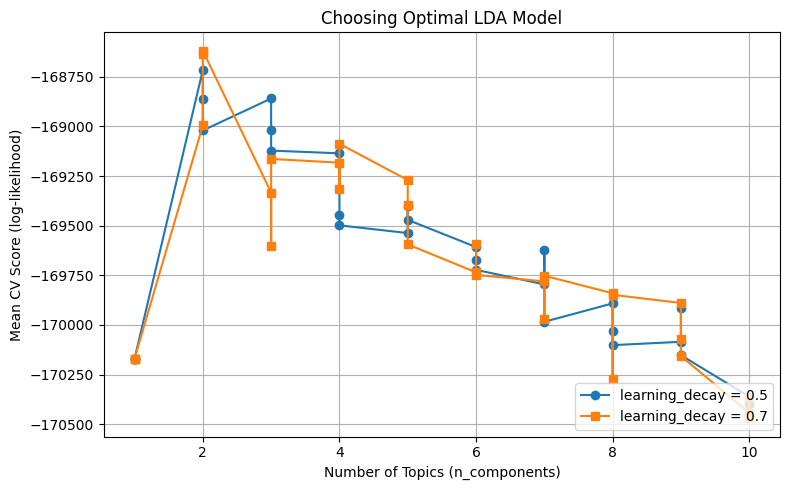

In [137]:

# Use cv_results_ (not best_params_)
cv = model.cv_results_

# Extract arrays
ld = cv["param_learning_decay"].astype(float)   # learning_decay per run
nc = cv["param_n_components"].astype(int)       # number of topics per run
scores = np.asarray(cv["mean_test_score"], dtype=float)

def series_for_decay(decay):
    m = (ld == decay)
    t = nc[m]
    s = scores[m]
    order = np.argsort(t)
    return t[order], s[order]

plt.figure(figsize=(8,5))

# plot for decay=0.5 if present
if np.any(ld == 0.5):
    t5, s5 = series_for_decay(0.5)
    plt.plot(t5, s5, marker='o', label='learning_decay = 0.5')

# plot for decay=0.7 if present
if np.any(ld == 0.7):
    t7, s7 = series_for_decay(0.7)
    plt.plot(t7, s7, marker='s', label='learning_decay = 0.7')

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Number of Topics (n_components)")
plt.ylabel("Mean CV Score (log-likelihood)")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [138]:
print("Topic numbers for decay 0.9:", sorted(set(t5)))
print("Topic numbers for decay 0.7:", sorted(set(t7)))


Topic numbers for decay 0.9: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Topic numbers for decay 0.7: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Document-Topic Matrix

In [139]:
# Document-topic distribution
lda_output = best_lda_model.transform(X)

# Column names
topicnames = [f"Topic{i}" for i in range(best_lda_model.n_components)]

# Use student IDs (or keep Doc0..DocN if you prefer)
docnames = df_student["uni"].tolist()

# Build DataFrame
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Dominant topic + prob
df_document_topic["dominant_topic"] = df_document_topic[topicnames].values.argmax(axis=1)
df_document_topic["dominant_prob"]  = df_document_topic[topicnames].max(axis=1)

# Styling
def color_green(val):
    return "color: green" if val > 0.1 else "color: black"
def make_bold(val):
    return "font-weight: 700" if val > 0.1 else "font-weight: 400"

styled_preview = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

styled_preview


/tmp/ipython-input-3790091667.py:23: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_preview = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)


,Topic0,Topic1,Topic2,dominant_topic,dominant_prob
aa2301,0.970000,0.020000,0.020000,0,0.970000
aa3553,0.020000,0.900000,0.080000,1,0.900000
aa3715,0.650000,0.010000,0.330000,0,0.650000
aa3855,0.240000,0.700000,0.060000,1,0.700000
aa4228,0.970000,0.010000,0.010000,0,0.970000
aa4237,0.020000,0.540000,0.440000,1,0.540000
aa4378,0.860000,0.010000,0.130000,0,0.860000
aa4379,0.970000,0.010000,0.010000,0,0.970000
aa4385,0.930000,0.010000,0.060000,0,0.930000
aa4549,0.020000,0.970000,0.010000,1,0.970000


In [140]:
'''
Review topics distribution across documents
'''
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.head(10)

,Topic Num,Num Documents
0,0,3770
1,1,2061
2,2,1794


## visualize the LDA model with pyLDAvis-- broken

In [ ]:

import pyLDAvis

# 1. Topic–term distributions
topic_term_dists = best_lda_model.components_
topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1, keepdims=True)

# 2. Document–topic distributions
doc_topic_dists = best_lda_model.transform(X)

# 3. Vocabulary
vocab = vectorizer.get_feature_names_out()

# 4. Document lengths
doc_lengths = np.asarray(X.sum(axis=1)).ravel()

# 5. Term frequencies
term_frequency = np.asarray(X.sum(axis=0)).ravel()

# Check
print(topic_term_dists.shape, doc_topic_dists.shape, len(vocab), len(doc_lengths), len(term_frequency))



In [ ]:

pyLDAvis.enable_notebook()
panel = pyLDAvis.prepare(best_lda_model, X, vectorizer, mds='tsne', vocab= vocab, term_frequency=term_frequency)
panel

## Topic Keywords

In [141]:
'''
see the Topic’s keywords
'''

# Column names = vocabulary
terms = vectorizer.get_feature_names_out()            # shape: (n_terms,)

# Row names = topics
topicnames = [f"Topic{i}" for i in range(best_lda_model.n_components)]

# Topic–keyword matrix as a DataFrame
df_topic_keywords = pd.DataFrame(best_lda_model.components_,  # (n_topics, n_terms)
                                 index=topicnames,
                                 columns=terms)

# View top-N keywords per topic
TOP_N = 10
for t in range(best_lda_model.n_components):
    top_idx = np.argsort(df_topic_keywords.iloc[t].values)[-TOP_N:][::-1]
    top_terms = terms[top_idx]
    top_weights = df_topic_keywords.iloc[t, top_idx].values
    print(f"Topic {t}: " + ", ".join(top_terms))


Topic 0: analysis, strategy, marketing, business analytics, leadership, entrepreneurship, management, business, manager, operation
Topic 1: investing, analysis, finance, marketing, securities, corporate, security analysis, corporate finance, investment, capital markets
Topic 2: real estate, finance, marketing, entrepreneurship, management, business, capital markets, investment, climate, strategy


### Forcing keyword excusivity per topic

In [142]:
import numpy as np

# Components: (n_topics, n_terms)
phi = best_lda_model.components_            # learned topic-word weights
n_topics, n_terms = phi.shape

# For each term, pick the topic with the max weight
word_to_topic = phi.argmax(axis=0)          # shape: (n_terms,)

# Build a term→topic one-hot matrix W: (n_terms, n_topics)
W = np.zeros((n_terms, n_topics), dtype=np.float32)
W[np.arange(n_terms), word_to_topic] = 1.0

# Document-term matrix X: (n_docs, n_terms)
# Compute hard topic counts per document: (n_docs, n_topics)
T_counts = X @ W

# Normalize to get per-doc topic proportions (document–topic matrix)
T_sums = T_counts.sum(axis=1, keepdims=True)
T_sums[T_sums == 0] = 1.0                   # avoid divide-by-zero
theta_hard = T_counts / T_sums              # (n_docs, n_topics)

# Optional: top words per hard topic
terms = vectorizer.get_feature_names_out()
topn = 25
for t in range(n_topics):
    idx = np.where(word_to_topic == t)[0]
    # Rank those words by original phi weight for topic t
    if len(idx):
        order = np.argsort(phi[t, idx])[::-1][:topn]
        print(f"Topic {t}:", ", ".join(terms[idx[order]]))
    else:
        print(f"Topic {t}: (no words assigned)")


Topic 0: analysis, strategy, marketing, business analytics, leadership, entrepreneurship, management, business, manager, operation, investment, capital markets, organizational change, technology, python, program, economy, product management, society, product, internet, global immersion, decision making, sport, venture capital
Topic 1: investing, finance, securities, corporate, security analysis, corporate finance, acquisition, merger, financial statement analysis, equity, applied value investing, emerging markets, corporate transactions, debt, debt markets, calculation, accounting, derivative, financial modelling, financial markets, research, asset management, pension, activism, financial crises
Topic 2: real estate, climate, climate change, healthcare, private equity, family business, innovation, management digital age, brand management, digital health, family enterprise, macroeconomic, public policy, policy, cryptocurrencies, enterprise, food, food entrepreneurship, global economy, s

## cluster plot

In [143]:
'''
cluster documents that share similar topics and plot
'''
# Construct the k-means clusters

clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.89  0.35  0.3 ]
 [-0.45  0.78  0.42]]
Perc of Variance Explained: 
 [0.13 0.49]


In [ ]:
'''
Plot clusters
'''
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# LDA prep for Description